<a href="https://colab.research.google.com/github/sarenales/PrototypesVulnerabilities/blob/main/EjemploPrototipos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Basado en prototipos primero ejemplo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

### Dataset

In [ ]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
len(train_loader)

938

In [ ]:
len(test_loader)

157

### PrototypeNet

Esta arquitectura está definida por tres componentes principales:
- Autoencoder
  - Encoder : Convierte la entrada en una representación latente.
  - Decoder : Toma la representación latente y se contruye la imagen original. La salida se normaliza con Sigmoid para que esté en el rango [0,1].
- Capa de prototipos : Se definen 10 protipos, que son representaciones aprendibles en el espacio latente. Se inicializan aleatoriamente. Son parámetros entrenables, por lo que se optimizan durante el aprendizaje.
- Clasificador : Convierte las similitudes con los prototipos en predicciones sobre 10 clases (MNIST). Cada clase en MNIST se mapea a alguna combinación de prototipos.

In [ ]:
class PrototypeNetwork(nn.Module):
    def __init__(self, num_prototypes=10, latent_dim=64, input_dim=28*28):
        super(PrototypeNetwork, self).__init__()
        # Codificador
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Prototipos
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, latent_dim))

        # Clasificador
        self.classifier = nn.Linear(num_prototypes, 10)  # 10 clases en MNIST

        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),  # Reconstruir la entrada original (tamaño 28x28 aplanado)
            nn.Sigmoid()  # Normalizar entre 0 y 1
        )

    def forward(self, x):
        # Codificador
        x = x.view(x.size(0), -1)  # Aplanar la imagen
        z = self.encoder(x)

        # Similitudes con prototipos
        prototype_distances = torch.cdist(z, self.prototypes, p=2)
        similarities = -prototype_distances  # Similitudes inversas a la distancia

        # Clasificador
        logits = self.classifier(similarities)

        # Reconstrucción (añadido)
        reconstruction = self.decoder(z)

        return logits, similarities, reconstruction


Medimos qué tan bien o mal está funcionando el modelo comparando su salida con el valor esperado.

In [ ]:
def prototype_loss(logits, targets, similarities, prototypes, original_input, reconstruction, alpha=1.0, beta=0.1):
    # Pérdida de clasificación
    classification_loss = nn.CrossEntropyLoss()(logits, targets)

    # Pérdida de dispersión de prototipos (penaliza prototipos muy cercanos)
    prototype_distances = torch.cdist(prototypes, prototypes, p=2)
    diversity_loss = torch.mean(torch.triu(prototype_distances, diagonal=1))

    # Pérdida de reconstrucción
    reconstruction_loss = nn.MSELoss()(reconstruction, original_input.view(original_input.size(0), -1))

    # Pérdida total
    total_loss = classification_loss + alpha * (1 / diversity_loss) + beta * reconstruction_loss
    return total_loss


#### Entrenamiento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypeNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo de entrenamiento
for epoch in range(100):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        logits, similarities, reconstruction = model(images)

        # Calcular pérdida
        loss = prototype_loss(logits, labels, similarities, model.prototypes, images, reconstruction)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 1.4691605695020924
Epoch 2, Loss: 0.5178397412239107
Epoch 3, Loss: 0.42819837402941574
Epoch 4, Loss: 0.38078719244074466
Epoch 5, Loss: 0.35104106963951703
Epoch 6, Loss: 0.3279745158737402
Epoch 7, Loss: 0.3101820951458742
Epoch 8, Loss: 0.29472125555152323
Epoch 9, Loss: 0.28769231903781767
Epoch 10, Loss: 0.27453557303401704
Epoch 11, Loss: 0.26701906334553194
Epoch 12, Loss: 0.2611942013570749
Epoch 13, Loss: 0.25154398073519724
Epoch 14, Loss: 0.2469815693017262
Epoch 15, Loss: 0.24235545421269403
Epoch 16, Loss: 0.23390533697249286
Epoch 17, Loss: 0.23300969767481533
Epoch 18, Loss: 0.22552503337229746
Epoch 19, Loss: 0.22400158586532576
Epoch 20, Loss: 0.21946935454157115
Epoch 21, Loss: 0.21624475681006528
Epoch 22, Loss: 0.211072742240007
Epoch 23, Loss: 0.20961933606850314
Epoch 24, Loss: 0.20776406969470002
Epoch 25, Loss: 0.20230592329746117
Epoch 26, Loss: 0.202406600213
Epoch 27, Loss: 0.19801646825283575
Epoch 28, Loss: 0.19405288935533718
Epoch 29, Loss

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits[1], dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Test Accuracy: 9.69%


#### Visualización de las representaciones latentes (z) y los prototipos

Se presentan distribuidos en un espacio de dos dimensiones usando PCA (Análisis de Componentes Principales).

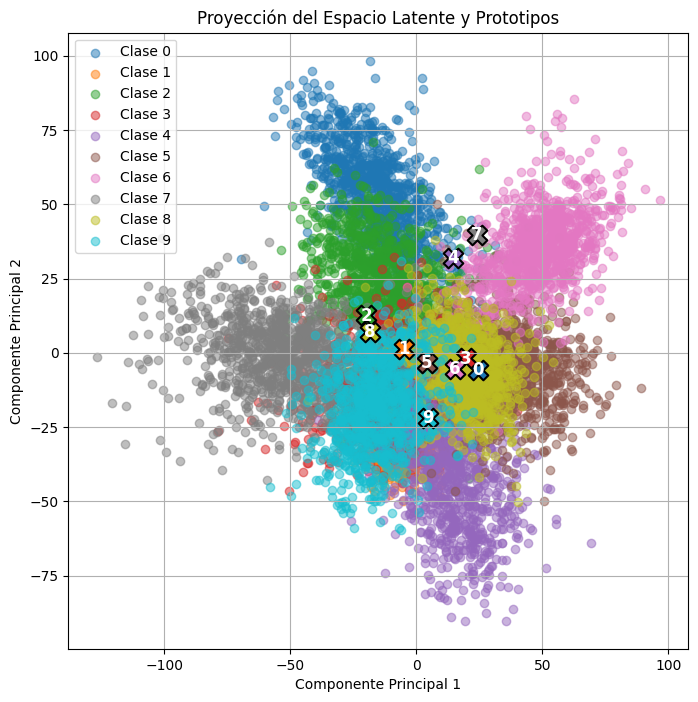

In [ ]:
# Obtener las representaciones latentes (f(x)) y prototipos
model.eval()
latent_features = []
labels = []

with torch.no_grad():
    for images, lbls in test_loader: # train_loader
        images = images.to(device)
        z = model.encoder(images.view(images.size(0), -1))
        latent_features.append(z.cpu().numpy())
        labels.extend(lbls.numpy())

# Concatenar latentes
latent_features = np.vstack(latent_features)
labels = np.array(labels)

# Reducir dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)
prototypes_2d = pca.transform(model.prototypes.detach().cpu().numpy())

# Graficar
plt.figure(figsize=(8, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 10 colores diferentes para las clases

for i in range(10):  # 10 clases en MNIST
    idx = labels == i
    plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=f"Clase {i}", alpha=0.5, color=colors[i])

# Graficar prototipos con colores y etiquetas diferentes
for j, (px, py) in enumerate(prototypes_2d):
    plt.scatter(px, py, color=colors[j % 10], marker="X", s=200, edgecolors="black", linewidth=1.5)
    plt.text(px, py, str(j), fontsize=12, fontweight="bold", ha='center', va='center', color="white")

plt.legend()
plt.title("Proyección del Espacio Latente y Prototipos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()


#### Heatmap

Se visualiza qué tan similares son las representaciones latentes de las imágenes con los prototipos.

- Si una fila tiene un valor alto en una columna, significa que esa imagen es similar a ese prototipo.
- Si hay valores bien distribuidos, los prototipos son diversos y representan diferentes grupos.
- Si todo es muy uniforme, puede indicar que los prototipos no están capturando bien la variedad de los datos.

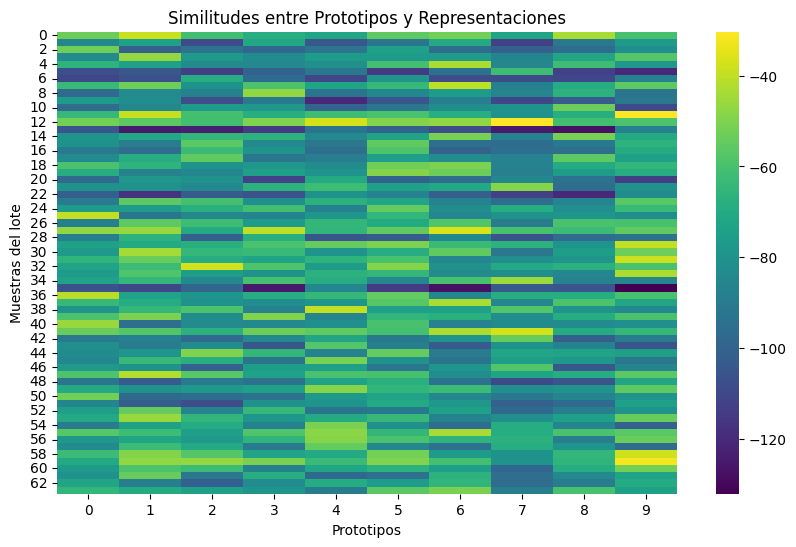

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular similitudes entre prototipos y un lote de datos
images, _ = next(iter(train_loader))
images = images.to(device)
z = model.encoder(images.view(images.size(0), -1))
similarities = -torch.cdist(z, model.prototypes, p=2).detach().cpu().numpy()

# Graficar la matriz de similitud
plt.figure(figsize=(10, 6))
sns.heatmap(similarities, cmap="viridis", annot=False)
plt.title("Similitudes entre Prototipos y Representaciones")
plt.xlabel("Prototipos")
plt.ylabel("Muestras del lote")
plt.show()


Se evalua la capacidad del modelo de reconstruir imágenes a partir de sus representaciones latentes. La idea es observar si la reconstrucción es lo suficientemente fiel a la imagen original o si el modelo está perdiendo detalles importantes.

Si las reconstrucciones son similares a las originales, significa que el modelo está aprendiendo una buena representación latente. Si no, puede ser necesario ajustar la arquitectura o la función de pérdida.

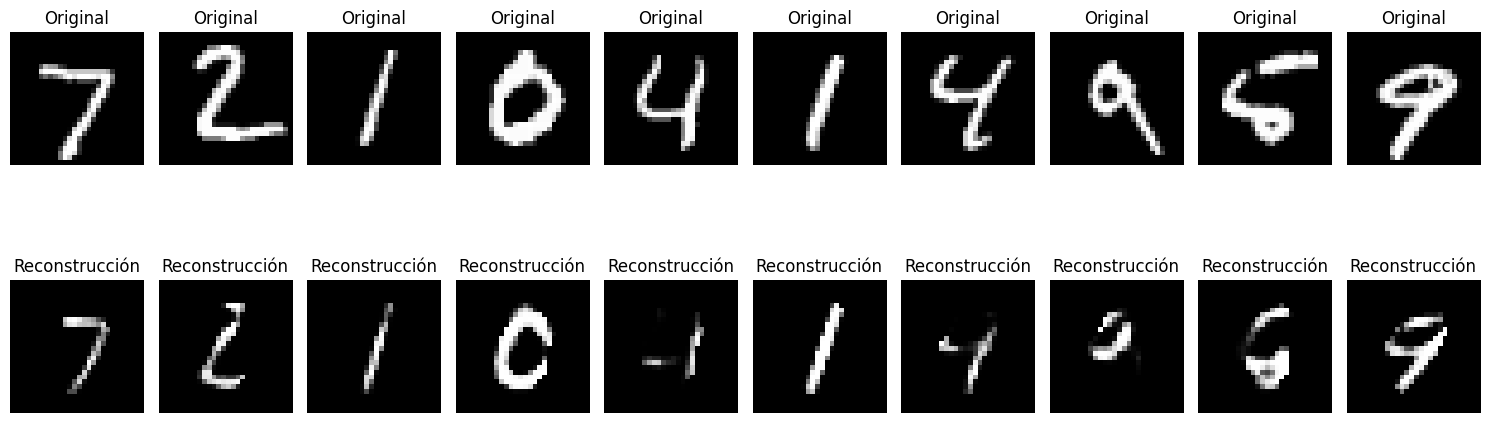

Ejemplo 1 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 1.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 2 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 0.0000
Clase 2: 0.9999
Clase 3: 0.0001
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 3 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 1.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 4 - Prototype Scores:
Clase 0: 1.0000
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 5 - Prototype Scores:
Clase 0: 0.0000
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 1.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000
-
Ejemplo 6 - Prototype Scores:
Clase 0: 0

In [ ]:
# Seleccionar un lote de imágenes
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Pasar las imágenes por el modelo
with torch.no_grad():
    logits, similarities, reconstructions = model(test_images)
    prototype_scores = F.softmax(logits, dim=1).cpu().numpy()  # Convertir a probabilidades

# Visualización de imágenes originales y reconstruidas
fig, axes = plt.subplots(2, 10, figsize=(15, 6))
for i in range(10):
    # Imagen original
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Reconstrucción
    axes[1, i].imshow(reconstructions[i].cpu().view(28, 28), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstrucción")

plt.tight_layout()
plt.show()

# Imprimir las probabilidades de cada clase por cada ejemplo
for i in range(10):
    print(f"Ejemplo {i+1} - Prototype Scores:")
    for j, prob in enumerate(prototype_scores[i]):
        print(f"Clase {j}: {prob:.4f}")
    print("-")

## Primeros ataques


### FGSM
El FGSM (Fast Gradient Sign Method) funciona generando pequeñas perturbaciones en la entrada para engañar al modelo. Se basa en calcular el gradiente de la pérdida con respecto a la entrada y añadir una perturbación controlada.

Definir la Función de Ataque FGSM

In [ ]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    images.requires_grad = True

    # Obtener la salida del modelo antes del ataque
    outputs = model(images)
    if isinstance(outputs, tuple):
        outputs = outputs[0]

    # Obtener probabilidades antes del ataque
    probs_before = F.softmax(outputs, dim=1).detach().cpu().numpy()

    # Calcular la pérdida
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Generar la perturbación adversarial
    perturbation = epsilon * images.grad.sign()
    adv_images = torch.clamp(images + perturbation, 0, 1)

    # Obtener la salida del modelo después del ataque
    adv_outputs = model(adv_images)
    if isinstance(adv_outputs, tuple):
        adv_outputs = adv_outputs[0]

    # Obtener probabilidades después del ataque
    probs_after = F.softmax(adv_outputs, dim=1).detach().cpu().numpy()

    return adv_images, probs_before, probs_after


Aplicar el Ataque a un Lote de Datos

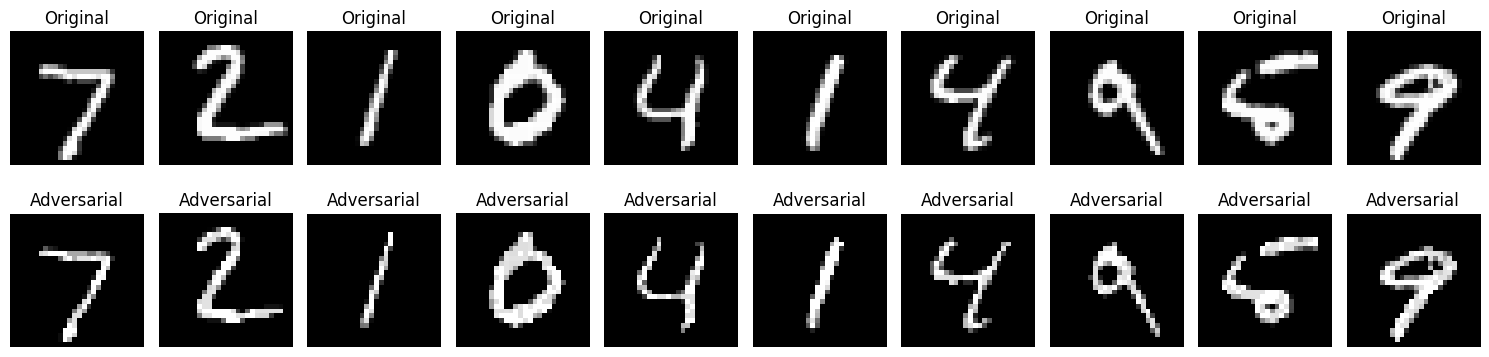

In [ ]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes y etiquetas
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Aplicar FGSM con epsilon = 0.1
epsilon = 0.1
adv_images,_ ,_ = fgsm_attack(model, images, labels, epsilon)

# Visualizar imágenes originales vs adversarias
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    # Imagen original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Imagen adversarial
    axes[1, i].imshow(adv_images[i].cpu().detach().squeeze(), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Adversarial")

plt.tight_layout()
plt.show()


Evaluar el Impacto del Ataque

In [ ]:
original_preds = model(images)[0].argmax(dim=1)
adv_preds = model(adv_images)[0].argmax(dim=1)


# Comparar resultados
print("Etiquetas reales:   ", labels[:10].cpu().numpy())
print("Predicciones normales: ", original_preds[:10].cpu().numpy())
print("Predicciones adversarias:", adv_preds[:10].cpu().numpy())


Etiquetas reales:    [7 2 1 0 4 1 4 9 5 9]
Predicciones normales:  [7 2 1 0 4 1 4 9 6 9]
Predicciones adversarias: [7 3 1 0 9 1 4 7 5 7]


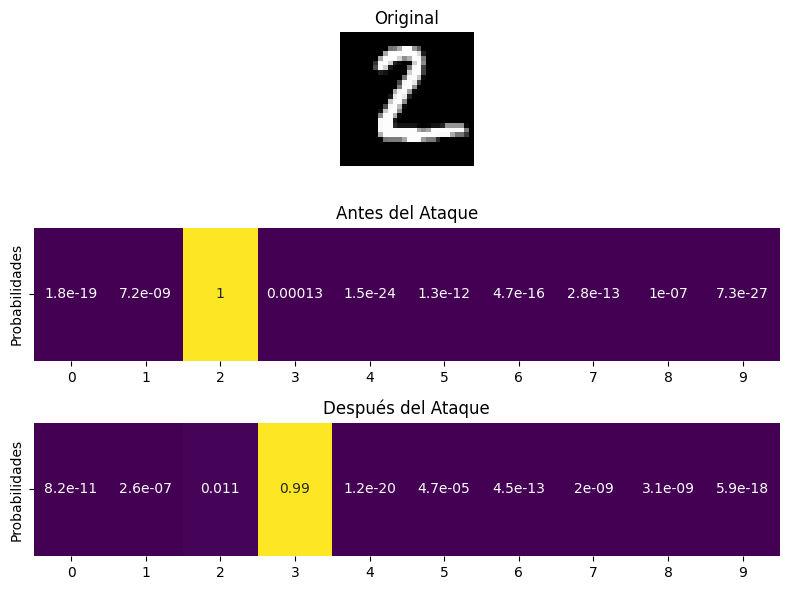

In [ ]:
# Seleccionar solo un ejemplo
example_image = test_images[1].unsqueeze(0)
example_label = test_labels[1].unsqueeze(0)

# Aplicar FGSM
epsilon = 0.1
adv_image, probs_before, probs_after = fgsm_attack(model, example_image, example_label, epsilon)

# Visualización de la imagen y las probabilidades
fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# Imagen original
axes[0].imshow(example_image.cpu().squeeze(), cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original")

#axes[1].imshow(adv_image.cpu().detach().squeeze(), cmap="gray")
#axes[1].axis("off")
#axes[1].set_title("Adversarial")

# Probabilidades antes del ataque
sns.heatmap(probs_before, cmap="viridis", annot=True, cbar=False, ax=axes[1], xticklabels=range(probs_before.shape[1]), yticklabels=["Probabilidades"])
axes[1].set_title("Antes del Ataque")

# Probabilidades después del ataque
sns.heatmap(probs_after, cmap="viridis", annot=True, cbar=False, ax=axes[2], xticklabels=range(probs_after.shape[1]), yticklabels=["Probabilidades"])
axes[2].set_title("Después del Ataque")

plt.tight_layout()
plt.show()


# Aprendizaje Basado en prototipos segundo ejemplo

autoencoder_helpers.py

In [1]:
import os
import tensorflow as tf

In [2]:
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = tf.reshape(list_of_norms(X), shape=(-1, 1))
    YY = tf.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * tf.matmul(X, tf.transpose(Y))

    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return tf.reduce_sum(tf.pow(X, 2), axis=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')

CAE_MNIST.py

Autoencoder convolucional (CAE, Convolutional Autoencoder) basado en TensorFlow 1.x para el conjunto de datos MNIST (imágenes de dígitos manuscritos).

Su propósito es aprender una representación comprimida de las imágenes a través de un encoder y reconstruirlas a través de un decoder. Además, integra un mecanismo basado en prototipos, probablemente para clasificación o análisis de características.

In [7]:
!pip install tensorflow.examples

ERROR: Could not find a version that satisfies the requirement tensorflow.examples (from versions: none)
ERROR: No matching distribution found for tensorflow.examples


In [11]:
from __future__ import division, print_function, absolute_import
import os
import time
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [9]:
from tensorflow.keras.datasets import mnist

# Cargar el dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizar las imágenes al rango [0,1]
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Mostrar una imagen de ejemplo
plt.imshow(x_train[0], cmap='gray')
plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Mostrar una imagen de ejemplo
plt.imshow(x_train[0], cmap='gray')
plt.show()

In [14]:
# mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

GPUID = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)

# the directory to save the model
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model", "mnist_cae_1")
makedirs(model_folder)
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)
model_filename = "mnist_cae"
# the maximum number of model snapshots we allow tensorflow to save to disk
# when set to None there is no limit
n_saves = None
# console_log is the handle to a text file that records the console output
console_log = open(os.path.join(model_folder, "console_log.txt"), "w+")

In [18]:
# training parameters
learning_rate = 0.002
training_epochs = 1500
batch_size = 250          # the size of a minibatch
test_display_step = 100   # how many epochs we do evaluate on the test set once
save_step = 50            # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha = 20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1
lambda_1 = 1              # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1


input_height = 28         # MNIST data input shape
input_width = input_height
n_input_channel = 1       # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # the number of pixels in one input image
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4

# height and width of each layers' filters
f_1 = 3
f_2 = 3
f_3 = 3
f_4 = 3

# stride size in each direction for each of the layers
s_1 = 2
s_2 = 2
s_3 = 2
s_4 = 2

# number of feature maps in each layer
n_map_1 = 32
n_map_2 = 32
n_map_3 = 32
n_map_4 = 10

# the shapes of each layer's filter
filter_shape_1 = [f_1, f_1, n_input_channel, n_map_1]
filter_shape_2 = [f_2, f_2, n_map_1, n_map_2]
filter_shape_3 = [f_3, f_3, n_map_2, n_map_3]
filter_shape_4 = [f_4, f_4, n_map_3, n_map_4]

stride_1 = [1, s_1, s_1, 1]
stride_2 = [1, s_2, s_2, 1]
stride_3 = [1, s_3, s_3, 1]
stride_4 = [1, s_4, s_4, 1]

# tf Graph input
# X is the 2-dimensional matrix whose every row is an image example.
# Y is the 2-dimensional matrix whose every row is the one-hot encoding label.
#X = tf.placeholder(dtype=tf.float32, shape=[None, input_size], name='X')
# X_img = tf.reshape(X, shape=[-1, input_height, input_width, n_input_channel], name='X_img')
#Y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='Y')

X = tf.keras.Input(shape=(input_size,), dtype=tf.float32, name='X')
Y = tf.keras.Input(shape=(n_classes,), dtype=tf.float32, name='Y')

print("Placeholder eliminado. Se usa keras.Input.")

# We create a tf placeholder for every lambda so that they can be tweaked during training
lambda_class_t = tf.placeholder(dtype=tf.float32, shape=(), name="lambda_class_t")
lambda_ae_t = tf.placeholder(dtype=tf.float32, shape=(), name="lambda_ae_t")
lambda_2_t = tf.placeholder(dtype=tf.float32, shape=(), name="lambda_2_t")
lambda_1_t = tf.placeholder(dtype=tf.float32, shape=(), name="lambda_1_t")

weights = {
    'enc_f1': tf.Variable(tf.random_normal(filter_shape_1,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='encoder_f1'),
    'enc_f2': tf.Variable(tf.random_normal(filter_shape_2,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='encoder_f2'),
    'enc_f3': tf.Variable(tf.random_normal(filter_shape_3,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='encoder_f3'),
    'enc_f4': tf.Variable(tf.random_normal(filter_shape_4,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='encoder_f4'),
    'dec_f4': tf.Variable(tf.random_normal(filter_shape_4,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='decoder_f4'),
    'dec_f3': tf.Variable(tf.random_normal(filter_shape_3,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='decoder_f3'),
    'dec_f2': tf.Variable(tf.random_normal(filter_shape_2,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='decoder_f2'),
    'dec_f1': tf.Variable(tf.random_normal(filter_shape_1,
                                           stddev=0.01,
                                           dtype=tf.float32),
                          name='decoder_f1')
}

biases = {
    'enc_b1': tf.Variable(tf.zeros([n_map_1], dtype=tf.float32),
                          name='encoder_b1'),
    'enc_b2': tf.Variable(tf.zeros([n_map_2], dtype=tf.float32),
                          name='encoder_b2'),
    'enc_b3': tf.Variable(tf.zeros([n_map_3], dtype=tf.float32),
                          name='encoder_b3'),
    'enc_b4': tf.Variable(tf.zeros([n_map_4], dtype=tf.float32),
                          name='encoder_b4'),
    'dec_b4': tf.Variable(tf.zeros([n_map_3], dtype=tf.float32),
                          name='decoder_b4'),
    'dec_b3': tf.Variable(tf.zeros([n_map_2], dtype=tf.float32),
                          name='decoder_b3'),
    'dec_b2': tf.Variable(tf.zeros([n_map_1], dtype=tf.float32),
                          name='decoder_b2'),
    'dec_b1': tf.Variable(tf.zeros([n_input_channel], dtype=tf.float32),
                          name='decoder_b1')
}

last_layer = {
    'w': tf.Variable(tf.random_uniform(shape=[n_prototypes, n_classes],
                                       dtype=tf.float32),
                     name='last_layer_w')
}

Placeholder eliminado. Se usa keras.Input.


AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
# padding can be either "SAME" or "VALID"
def conv_layer(input, filter, bias, strides, padding="VALID", nonlinearity=tf.nn.relu):
    conv = tf.nn.conv2d(input, filter, strides=strides, padding=padding)
    act = nonlinearity(conv + bias)
    return act

# tensorflow's conv2d_transpose needs to know the shape of the output
def deconv_layer(input, filter, bias, output_shape, strides, padding="VALID", nonlinearity=tf.nn.relu):
    deconv = tf.nn.conv2d_transpose(input, filter, output_shape, strides, padding=padding)
    act = nonlinearity(deconv + bias)
    return act

def fc_layer(input, weight, bias, nonlinearity=tf.nn.relu):
    return nonlinearity(tf.matmul(input, weight) + bias)

# construct the model
# eln means the output of the nth layer of the encoder
el1 = conv_layer(X_img, weights['enc_f1'], biases['enc_b1'], stride_1, "SAME")
el2 = conv_layer(el1, weights['enc_f2'], biases['enc_b2'], stride_2, "SAME")
el3 = conv_layer(el2, weights['enc_f3'], biases['enc_b3'], stride_3, "SAME")
el4 = conv_layer(el3, weights['enc_f4'], biases['enc_b4'], stride_4, "SAME")

# we compute the output shape of each layer because the deconv_layer function requires it
l1_shape = el1.get_shape().as_list()
l2_shape = el2.get_shape().as_list()
l3_shape = el3.get_shape().as_list()
l4_shape = el4.get_shape().as_list()

flatten_size = l4_shape[1] * l4_shape[2] * l4_shape[3]
n_features = flatten_size
# feature vectors is the flattened output of the encoder
feature_vectors = tf.reshape(el4, shape=[-1, flatten_size], name='feature_vectors')

# the list prototype feature vectors
prototype_feature_vectors = tf.Variable(tf.random_uniform(shape=[n_prototypes, n_features],
                                                          dtype=tf.float32),
                                        name='prototype_feature_vectors')

'''deconv_batch_size is the number of feature vectors in the batch going into
the deconvolutional network. This is required by the signature of
conv2d_transpose. But instead of feeding in the value, the size is infered during
sess.run by looking at how many rows the feature_vectors matrix has
'''
deconv_batch_size = tf.identity(tf.shape(feature_vectors)[0], name="deconv_batch_size")

# this is necessary for prototype images evaluation
reshape_feature_vectors = tf.reshape(feature_vectors, shape=[-1, l4_shape[1], l4_shape[2], l4_shape[3]])

# dln means the output of the nth layer of the decoder
dl4 = deconv_layer(reshape_feature_vectors, weights['dec_f4'], biases['dec_b4'],
                   output_shape=[deconv_batch_size, l3_shape[1], l3_shape[2], l3_shape[3]],
                   strides=stride_4, padding="SAME")
dl3 = deconv_layer(dl4, weights['dec_f3'], biases['dec_b3'],
                   output_shape=[deconv_batch_size, l2_shape[1], l2_shape[2], l2_shape[3]],
                   strides=stride_3, padding="SAME")
dl2 = deconv_layer(dl3, weights['dec_f2'], biases['dec_b2'],
                   output_shape=[deconv_batch_size, l1_shape[1], l1_shape[2], l1_shape[3]],
                   strides=stride_2, padding="SAME")
dl1 = deconv_layer(dl2, weights['dec_f1'], biases['dec_b1'],
                   output_shape=[deconv_batch_size, input_height, input_width, n_input_channel],
                   strides=stride_1, padding="SAME", nonlinearity=tf.nn.sigmoid)
'''
X_decoded is the decoding of the encoded feature vectors in X;
we reshape it to match the shape of the training input
X_true is the correct output for the autoencoder
'''
X_decoded = tf.reshape(dl1, shape=[-1, input_size], name='X_decoded')
X_true = tf.identity(X, name='X_true')

'''
prototype_distances is the list of distances from each x_i to every prototype
in the latent space
feature_vector_distances is the list of distances from each prototype to every x_i
in the latent space
'''
prototype_distances = list_of_distances(feature_vectors,
                                        prototype_feature_vectors)
prototype_distances = tf.identity(prototype_distances, name='prototype_distances')
feature_vector_distances = list_of_distances(prototype_feature_vectors,
                                             feature_vectors)
feature_vector_distances = tf.identity(feature_vector_distances, name='feature_vector_distances')

# the logits are the weighted sum of distances from prototype_distances
logits = tf.matmul(prototype_distances, last_layer['w'], name='logits')
probability_distribution = tf.nn.softmax(logits=logits,
                                         name='probability_distribution')

'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
ae_error = tf.reduce_mean(list_of_norms(X_decoded - X_true), name='ae_error')
class_error = tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=logits)
class_error = tf.identity(class_error, name='class_error')
error_1 = tf.reduce_mean(tf.reduce_min(feature_vector_distances, axis = 1), name='error_1')
error_2 = tf.reduce_mean(tf.reduce_min(prototype_distances, axis = 1), name='error_2')

# total_error is the our minimization objective
total_error = lambda_class_t * class_error +\
              lambda_ae_t * ae_error + \
              lambda_1_t * error_1 + \
              lambda_2_t * error_2
total_error = tf.identity(total_error, name='total_error')

# accuracy is not the classification error term; it is the percentage accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1),
                              tf.argmax(Y, 1),
                              name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32),
                          name='accuracy')

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(total_error)
#add the optimizer to collection so that we can retrieve the optimizer and resume training
tf.add_to_collection("optimizer", optimizer)

# Create the variable init operation and a saver object to store the model
init = tf.global_variables_initializer()

hyperparameters = {
	"learning_rate": learning_rate,
    "training_epochs": training_epochs,
    "batch_size": batch_size,
    "test_display_step": test_display_step,
    "save_step": save_step,

    "lambda_class": lambda_class,
    "lambda_ae": lambda_ae,
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,

    "input_height": input_height,
    "input_width": input_width,
    "n_input_channel": n_input_channel,
    "input_size": input_size,
    "n_classes": n_classes,

    "n_prototypes": n_prototypes,
    "n_layers": n_layers,

    "f_1":	f_1,
    "f_2":	f_2,
    "f_3": 	f_3,
    "f_4": 	f_4,

    "s_1" :s_1,
    "s_2": s_2,
    "s_3": s_3,
    "s_4": s_4,

    "n_map_1": n_map_1,
    "n_map_2": n_map_2,
    "n_map_3": n_map_3,
    "n_map_4": n_map_4,

    "n_features": n_features,
}
# save the hyperparameters above in the model snapshot
for (name, value) in hyperparameters.items():
    tf.add_to_collection('hyperparameters', tf.constant(name=name, value=value))

saver = tf.train.Saver(max_to_keep=n_saves)

config = tf.ConfigProto()
# the amount of GPU memory our process occupies
config.gpu_options.per_process_gpu_memory_fraction = 0.3
with tf.Session(config=config) as sess:
    sess.run(init)
    # we compute the number of batches because both training and evaluation
    # happens batch by batch; we do not throw the entire test set onto the GPU
    n_train_batch = mnist.train.num_examples // batch_size
    n_valid_batch = mnist.validation.num_examples // batch_size
    n_test_batch = mnist.test.num_examples // batch_size
    # Training cycle
    for epoch in range(training_epochs):
        print_and_write("#"*80, console_log)
        print_and_write("Epoch: %04d" % (epoch), console_log)
        start_time = time.time()
        train_ce, train_ae, train_e1, train_e2, train_te, train_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        # Loop over all batches
        for i in range(n_train_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            elastic_batch_x = batch_elastic_transform(batch_x, sigma=sigma, alpha=alpha, height=input_height, width=input_width)
            _, ce, ae, e1, e2, te, ac = sess.run(
                                    (optimizer,
                                    class_error,
                                    ae_error,
                                    error_1,
                                    error_2,
                                    total_error,
                                    accuracy),
                                    feed_dict={X: elastic_batch_x,
                                               Y: batch_y,
                                               lambda_class_t: lambda_class,
                                               lambda_ae_t: lambda_ae,
                                               lambda_1_t: lambda_1,
                                               lambda_2_t: lambda_2})
            train_ce += (ce/n_train_batch)
            train_ae += (ae/n_train_batch)
            train_e1 += (e1/n_train_batch)
            train_e2 += (e2/n_train_batch)
            train_te += (te/n_train_batch)
            train_ac += (ac/n_train_batch)
        end_time = time.time()
        print_and_write('training takes {0:.2f} seconds.'.format((end_time - start_time)), console_log)
        # after every epoch, check the error terms on the entire training set
        print_and_write("training set errors:", console_log)
        print_and_write("\tclassification error: {:.6f}".format(train_ce), console_log)
        print_and_write("\tautoencoder error: {:.6f}".format(train_ae), console_log)
        print_and_write("\terror_1: {:.6f}".format(train_e1), console_log)
        print_and_write("\terror_2: {:.6f}".format(train_e2), console_log)
        print_and_write("\ttotal error: {:.6f}".format(train_te), console_log)
        print_and_write("\taccuracy: {:.4f}".format(train_ac), console_log)

        # validation set error terms evaluation
        valid_ce, valid_ae, valid_e1, valid_e2, valid_te, valid_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        # Loop over all batches
        for i in range(n_valid_batch):
            batch_x, batch_y = mnist.validation.next_batch(batch_size)
            ce, ae, e1, e2, te, ac = sess.run(
                                    (class_error,
                                    ae_error,
                                    error_1,
                                    error_2,
                                    total_error,
                                    accuracy),
                                    feed_dict={X: batch_x,
                                               Y: batch_y,
                                               lambda_class_t: lambda_class,
                                               lambda_ae_t: lambda_ae,
                                               lambda_2_t: lambda_2,
                                               lambda_1_t: lambda_1})
            valid_ce += ce/n_valid_batch
            valid_ae += ae/n_valid_batch
            valid_e1 += e1/n_valid_batch
            valid_e2 += e2/n_valid_batch
            valid_te += te/n_valid_batch
            valid_ac += ac/n_valid_batch

        # after every epoch, check the error terms on the entire training set
        print_and_write("validation set errors:", console_log)
        print_and_write("\tclassification error: {:.6f}".format(valid_ce), console_log)
        print_and_write("\tautoencoder error: {:.6f}".format(valid_ae), console_log)
        print_and_write("\terror_1: {:.6f}".format(valid_e1), console_log)
        print_and_write("\terror_2: {:.6f}".format(valid_e2), console_log)
        print_and_write("\ttotal error: {:.6f}".format(valid_te), console_log)
        print_and_write("\taccuracy: {:.4f}".format(valid_ac), console_log)

        # test set accuracy evaluation
        if epoch % test_display_step == 0 or epoch == training_epochs - 1:
            test_ac = 0.0
            for i in range(n_test_batch):
                batch_x, batch_y = mnist.test.next_batch(batch_size)
                ac = sess.run(accuracy,
                              feed_dict={X: batch_x,
                                         Y: batch_y})
                test_ac += ac/n_test_batch

            # after every epoch, check the error terms on the entire training set
            print_and_write("test set:", console_log)
            print_and_write("\taccuracy: {:.4f}".format(test_ac), console_log)

        if epoch % save_step == 0 or epoch == training_epochs - 1:
            # one .meta file is enough to recover the computational graph
            saver.save(sess, os.path.join(model_folder, model_filename),
                       global_step=epoch,
                       write_meta_graph=(epoch == 0 or epoch == training_epochs - 1))

            prototype_imgs = sess.run(X_decoded,
                                      feed_dict={feature_vectors: prototype_feature_vectors.eval()})
            # visualize the prototype images
            n_cols = 5
            n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
            g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
            for i in range(n_rows):
                for j in range(n_cols):
                    if i*n_cols + j < n_prototypes:
                        b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                        cmap='gray',
                                        interpolation='none')
                        b[i][j].axis('off')

            plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch) + '.png'),
                        transparent=True,
                        bbox_inches='tight',
                        pad_inches=0)
            plt.close()

            # Applying encoding and decoding over a small subset of the training set
            examples_to_show = 10
            encode_decode = sess.run(X_decoded,
                                     feed_dict={X: mnist.train.images[:examples_to_show]})

            # Compare original images with their reconstructions
            f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
            for i in range(examples_to_show):
                a[0][i].imshow(mnist.train.images[i].reshape(input_height, input_width),
                                cmap='gray',
                                interpolation='none')
                a[0][i].axis('off')
                a[1][i].imshow(encode_decode[i].reshape(input_height, input_width),
                                cmap='gray',
                                interpolation='none')
                a[1][i].axis('off')

            plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch) + '.png'),
                        transparent=True,
                        bbox_inches='tight',
                        pad_inches=0)
            plt.close()
    print_and_write("Optimization Finished!", console_log)
console_log.close()

data_preprocessing.py


In [ ]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [ ]:
def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    '''
    this code is borrowed from chsasank on GitHubGist
    Elastic deformation of images as described in [Simard 2003].

    images: a two-dimensional numpy array; we can think of it as a list of flattened images
    sigma: the real-valued variance of the gaussian kernel
    alpha: a real-value that is multiplied onto the displacement fields

    returns: an elastically distorted image of the same shape
    '''
    assert len(images.shape) == 2
    # the two lines below ensure we do not alter the array images
    e_images = np.empty_like(images)
    e_images[:] = images

    e_images = e_images.reshape(-1, height, width)

    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]

    for i in range(e_images.shape[0]):

        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, 784)

In [ ]:
import matplotlib.pyplot as plt

'''
the following code demonstrates how gaussian_filter works by ploting
the displacement field before and after applying the gaussian_filter
'''
random_state = np.random.RandomState(None)
dx1 = random_state.rand(28, 28) * 2 - 1
dy1 = random_state.rand(28, 28) * 2 - 1
dx2 = gaussian_filter(dx1, 4, mode='constant')
dy2 = gaussian_filter(dy1, 4, mode='constant')
x, y = np.mgrid[0:28, 0:28]
plt.quiver(x, y, dx1, dy1)
plt.show()
plt.quiver(x, y, dx2, dy2)
plt.show()

mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
img = mnist.train.images[0]
plt.imshow(img.reshape(28, -1), cmap='gray')
plt.show()
dimg = elastic_transform(img.reshape(28, -1), sigma=4, alpha=20)
plt.imshow(dimg, cmap='gray')
plt.show()
plt.close()